In [3]:
!pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
directory = "Images/Medical Mask/annotations"
image_directory = "Images/Medical Mask/images"
df = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
    
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [4]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))

In [5]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [6]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

In [22]:
len(data)

5749

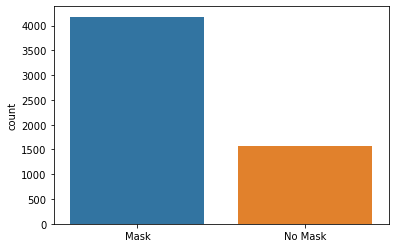

In [8]:
photos = []
for face in data:
    if(face[1] == 0):
        photos.append("Mask")
    else:
        photos.append("No Mask")
sns.countplot(photos)

In [9]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [10]:
X[0].shape

(124, 124, 3)

In [11]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 460800)            0

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [15]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [19]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
            steps_per_epoch=xtrain.shape[0]//32,
            epochs=20,
            verbose=1,
            validation_data=(xval, yval))

Epoch 1/10
143/143 [==============================] - 221s 2s/step - loss: 0.2491 - accuracy: 0.9045 - val_loss: 0.2195 - val_accuracy: 0.9096
Epoch 2/10
143/143 [==============================] - 234s 2s/step - loss: 0.2319 - accuracy: 0.9098 - val_loss: 0.2084 - val_accuracy: 0.9157
Epoch 3/10
143/143 [==============================] - 236s 2s/step - loss: 0.2451 - accuracy: 0.9085 - val_loss: 0.2028 - val_accuracy: 0.9191
Epoch 4/10
143/143 [==============================] - 235s 2s/step - loss: 0.2396 - accuracy: 0.9085 - val_loss: 0.2045 - val_accuracy: 0.9235
Epoch 5/10
143/143 [==============================] - 240s 2s/step - loss: 0.2273 - accuracy: 0.9166 - val_loss: 0.1905 - val_accuracy: 0.9235
Epoch 6/10
143/143 [==============================] - 244s 2s/step - loss: 0.2285 - accuracy: 0.9164 - val_loss: 0.1918 - val_accuracy: 0.9183
Epoch 7/10
143/143 [==============================] - 239s 2s/step - loss: 0.2247 - accuracy: 0.9087 - val_loss: 0.1965 - val_accuracy: 0.9235

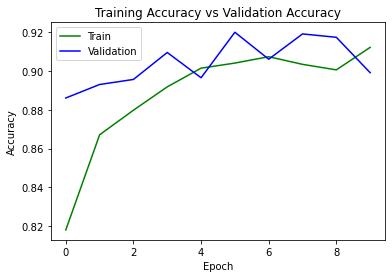

In [18]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
model.save('my_pretrained_model.h5')